In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [87]:
import sys
sys.path.append('../../')

from sdebridge.setup import *
from sdebridge.data_processing import butterfly1_pts, butterfly2_pts
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import BrownianSDE
from sdebridge.utils import eval_score

import matplotlib.pyplot as plt

In [159]:
def fourier_decompose(xs: jnp.ndarray, num_truncation: int = None) -> jnp.ndarray:
    coeffs = vmap(jnp.fft.rfft, in_axes=0)(xs)
    num_samples = xs.shape[-1]
    if num_truncation is None:
        num_truncation = num_samples
    coeffs = coeffs[..., :num_truncation] / num_samples
    return coeffs

def fourier_reconstruct(coeffs: jnp.ndarray, num_samples: int = None) -> jnp.ndarray:
    if num_samples is None:
        num_samples = coeffs.shape[-1]
    coeffs = coeffs * num_samples
    return vmap(partial(jnp.fft.irfft, n=num_samples), in_axes=0)(coeffs)

(2, 120)
(2, 120)


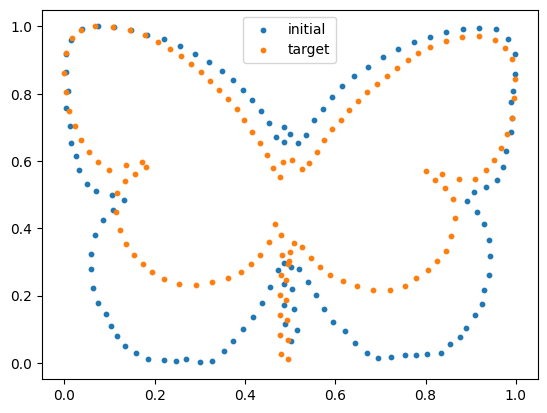

In [160]:
init_s = jnp.array(butterfly1_pts())[:, ::1861]
term_s = jnp.array(butterfly2_pts())[:, ::475]
print(init_s.shape)
print(term_s.shape)
plt.scatter(init_s[0], init_s[1], s=10, label='initial')
plt.scatter(term_s[0], term_s[1], s=10, label='target')
plt.legend()

(1, 64)


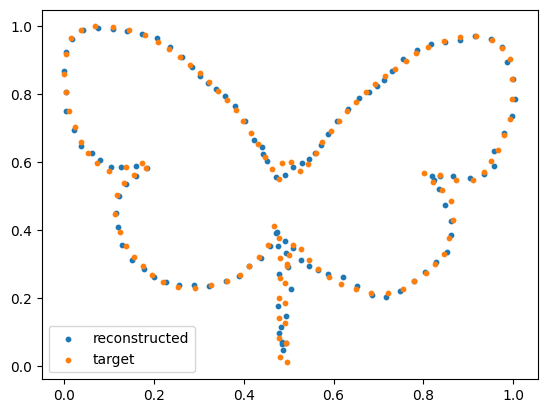

In [135]:
X0 = jnp.zeros((1, 64))

displacement = term_s - init_s
XT_complex = fourier_decompose(displacement, num_truncation=16)
displacement_recon = fourier_reconstruct(XT_complex, num_samples=120)
XT = jnp.concatenate([XT_complex.real, XT_complex.imag], axis=1)
print(XT.shape)

term_s_recon = init_s + displacement_recon
plt.scatter(term_s_recon[0], term_s_recon[1], s=10, label='reconstructed')
plt.scatter(term_s[0], term_s[1], s=10, label='target')
plt.legend()

In [136]:
sde_params = {
    "dimension": 64,
    "num_steps": 100,
}
sde = BrownianSDE(sde_params)
bridge = DiffusionBridge(sde)

In [138]:
setup_params = {
    "network": {
        "out_dim": sde.dim,
        "time_embedding_dim": 64,
        "encoding_dim": 64,
        "act": "gelu",
        "encoder_layer_dims": [64, 64, 64],
        "decoder_layer_dims": [64, 64, 64],
        "using_batchnorm": False,
    },
    "training": {
        "batch_size": 16,
        "num_epochs": 50,
        "num_batches_per_epoch": 50,
        "learning_rate": 1e-3,
    }
}

score_p_state = bridge.learn_p_score(
    initial_val=X0,
    setup_params=setup_params,
    rng_key = GLOBAL_RNG_KEY
)

Training: 100%|██████████| 50/50 [02:12<00:00,  2.66s/epoch, Epoch=50, loss=31.2720]


In [139]:
score_p = jax.tree_util.Partial(
    lambda val, time, score_p_state: eval_score(
        state=score_p_state,
        val=val,
        time=time,
    ),
    score_p_state=score_p_state
)
backward_brownian_bridge = bridge.simulate_backward_bridge(
    initial_val=X0,
    terminal_val=XT,
    score_p=score_p,
    rng_key=GLOBAL_RNG_KEY,
    num_batches=16,
)

In [140]:
print(backward_brownian_bridge["trajectories"].shape)

(16, 100, 64)


In [150]:
def real_to_complex(x: jnp.ndarray) -> jnp.ndarray:
    x = x.reshape(2, -1)
    dim = x.shape[-1] // 2
    return x[:, :dim] + 1j * x[:, dim:]

coeffs = vmap(vmap(real_to_complex, in_axes=0), in_axes=0)(backward_brownian_bridge["trajectories"])
print(coeffs.shape)
displacements = vmap(vmap(vmap(partial(jnp.fft.irfft, n=120))))(coeffs)
print(displacements.shape)

(16, 100, 2, 16)
(16, 100, 2, 120)


In [151]:
def eval_shape(s, dis):
    return s + dis

ss = vmap(vmap(eval_shape, in_axes=(None, 0)), in_axes=(None, 0))(init_s, displacements)
print(ss.shape)

(16, 100, 2, 120)


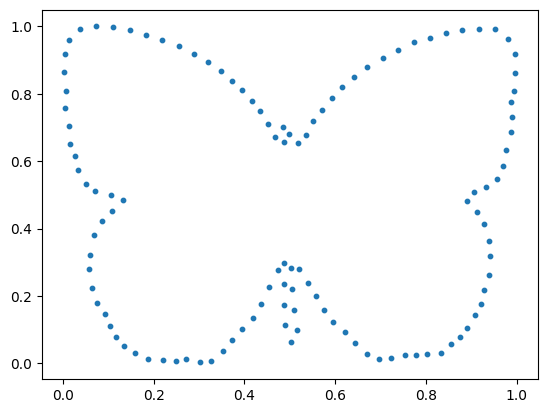

In [158]:
plt.scatter(ss[0, 0, 0], ss[0, 0, 1], s=10, label='reconstructed')